In [6]:
import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')


import os
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import cv2
from scipy.stats import uniform

from tqdm import tqdm
from glob import glob




In [8]:
dir_kaggle ='D:/sem 3/DIP/project'
data_kaggle ='D:/sem 3/DIP/project/dataset'
with_mask ='D:/sem 3/DIP/project/dataset/with_dataset'
without_mask='D:/sem 3/DIP/project/dataset/without_dataset'
class_data= ['with_mask','without_mask']
len_class_data = len(class_data)

In [9]:
image_count = {}
train_data = []

for i , class_data in tqdm(enumerate(class_data)):
    class_folder = os.path.join(data_kaggle,class_data)
    label = class_data
    image_count[class_data] = []
    
    for path in os.listdir(os.path.join(class_folder)):
        image_count[class_data].append(class_data)
        train_data.append(['{}/{}'.format(class_data, path), i, class_data])

2it [00:00, 1002.58it/s]


In [10]:
#show image count
for key, value in image_count.items():
    print('{0} -> {1}'.format(key, len(value)))

with_mask -> 220
without_mask -> 220


In [11]:
#create a dataframe
df = pd.DataFrame(train_data, columns=['file', 'id', 'label'])
df.shape
df.head()

,file,id,label
0,with_mask/image_0.png,0,with_mask
1,with_mask/image_1.png,0,with_mask
2,with_mask/image_10.png,0,with_mask
3,with_mask/image_100.png,0,with_mask
4,with_mask/image_101.png,0,with_mask


**IMAGE TRANSFORMATION**

In [13]:
#masking function
def create_mask_for_image(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

In [14]:
#image  gray  function
def  gray_image(image):
    mask = create_mask_for_image(image)
    output = cv2.cvtColor(image,  cv2.COLOR_BGR2GRAY)
    return output/255

In [15]:
#image  thresh  function
def  thresh_image(image):
    img = read_img(df['file'][250],(255,255))
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    output = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV) #+cv.THRESH_OTSU)
    return output

In [16]:
#image segmentation function
def segment_image(image):
    mask = create_mask_for_image(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

In [17]:
#sharpen the image
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [18]:

# function to get an image
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_kaggle, filepath), target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img

**SAMPLE IMAGE**

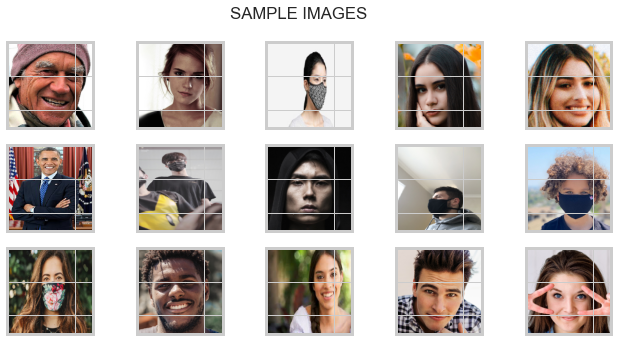

In [19]:
nb_rows = 3
nb_cols = 5
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 5));
plt.suptitle('SAMPLE IMAGES');
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        axs[i, j].xaxis.set_ticklabels([]);
        axs[i, j].yaxis.set_ticklabels([]);
        axs[i, j].imshow((read_img(df['file'][np.random.randint(400)], (255,255)))/255.);
plt.show();

**RESULT AFTER IMAGE TRANSFORMATION **

**MASK**

<ipython-input-20-ee8d088c596b>:9: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(1)


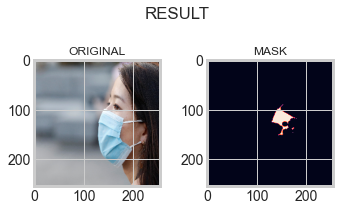

In [20]:
#get an image
img = read_img(df['file'][12],(255,255))

#mask
image_mask = create_mask_for_image(img)

fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout(1)

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('MASK', fontsize=12)

ax[0].imshow(img/255);
ax[1].imshow(image_mask);

**SEGMENTED**

<ipython-input-21-5b46a23ec3d9>:9: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(1)


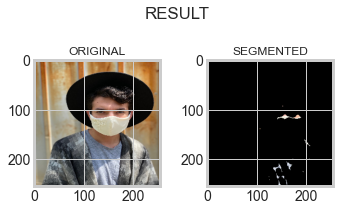

In [21]:
#get an image
img = read_img(df['file'][13],(255,255))

#segmentation
image_segmented = segment_image(img)

fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout(1)

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('SEGMENTED', fontsize=12)

ax[0].imshow(img/255);
ax[1].imshow(image_segmented);

**Grey**

<ipython-input-22-f7ae2b892d46>:9: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(1)


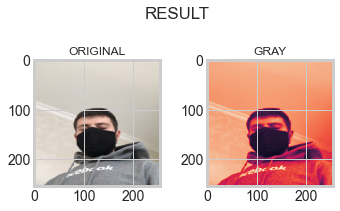

In [22]:
#get an image
img = read_img(df['file'][105],(255,255))

#gray
image_gray = gray_image(img)

fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout(1)

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('GRAY', fontsize=12)

ax[0].imshow(img/255);
ax[1].imshow(image_gray);

**THRESH**

<ipython-input-24-0483e7bd6852>:7: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(1)


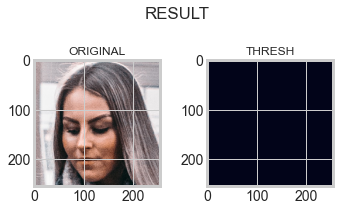

In [24]:
#get an image
img = read_img(df['file'][250],(255,255))
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV) #+cv.THRESH_OTSU)
fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout(1)

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('THRESH', fontsize=12)

ax[0].imshow(img/255);
ax[1].imshow(thresh);

**SHARPENING**

<ipython-input-26-abcc21ebee52>:9: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(1)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


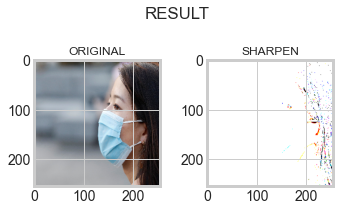

In [26]:
#get an image
img = read_img(df['file'][12],(255,255))

#sharpen the image
image_sharpen = sharpen_image(img)

fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout(1)

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('SHARPEN', fontsize=12)

ax[0].imshow(img/255);
ax[1].imshow(image_sharpen);

**Image Blurring (Image Smoothing)**

**averaging**

<ipython-input-29-fff80c3c5e88>:9: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(1)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


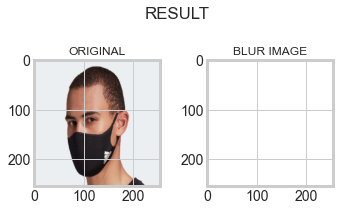

In [29]:
#get an image
img = read_img(df['file'][135],(255,255))

#Blur
blur = cv2.blur(img,(5,5))

fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout(1)

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('BLUR IMAGE', fontsize=12)

ax[0].imshow(img/255);
ax[1].imshow(blur);

gaussian filter


<ipython-input-30-984aed97df2b>:9: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(1)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


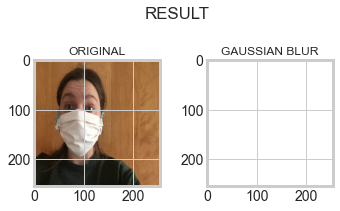

In [30]:
#get an image
img = read_img(df['file'][5],(255,255))

#GaussianBlur
Gblur = cv2.GaussianBlur(img,(5,5),0)

fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout(1)

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('GAUSSIAN BLUR', fontsize=12)

ax[0].imshow(img/255);
ax[1].imshow(Gblur);

**bilateral filtering**

<ipython-input-32-ca07d23f5232>:9: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(1)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


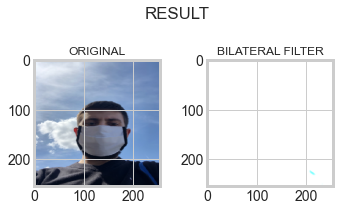

In [32]:
#get an image
img = read_img(df['file'][15],(255,255))

#BILATERAL FILTER
bilblur = cv2.bilateralFilter(img,9,75,75)

fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout(1)

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('BILATERAL FILTER', fontsize=12)

ax[0].imshow(img/255);
ax[1].imshow(bilblur);